In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


### Loading Series

In [101]:
# Pickling Call Volume 2018 series
redo_pickle = False

if redo_pickle == True:
    with open('hourly_call_volume_medical_2018.pickle','wb') as f:
        pickle.dump(hourly_call_volume_medical_2018,f)
        
if redo_pickle == False:
    with open('hourly_call_volume_medical_2018.pickle','rb') as f:
        hourly_call_volume_medical_2018 = pickle.load(f)

In [3]:
# Pickling All Call Volume series
redo_pickle = False

if redo_pickle == True:
    with open('hourly_call_volume_medical_all.pickle','wb') as f:
        pickle.dump(hourly_call_volume_medical_all,f)
        
if redo_pickle == False:
    with open('hourly_call_volume_medical_all.pickle','rb') as f:
        hourly_call_volume_medical_all = pickle.load(f)

In [103]:
# Pickling Unavailable Units 2018 series
redo_pickle = False

if redo_pickle == True:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','wb') as f:
        pickle.dump(unavailable_units_15_min_int_counts_2018_df,f)
        
if redo_pickle == False:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','rb') as f:
        unavailable_units_15_min_int_counts_2018_df = pickle.load(f)

### Functions

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def train_val_test_split(data):
    # Creating 60-20-20 train-validation-test split
    size_train_test = int(len(data) * 0.8)
    train, test = data[:size_train_test], data[size_train_test:]
    size_train_val = int(len(train) * 0.75)
    train, val = train[:size_train_val], train[size_train_val:]
    print('Train:',len(train))
    print('Validation:',len(val))
    print('Test:',len(test))
    return train, val, test

In [11]:
def lstm_predictions(train, val, model, n_steps, n_features):
    predictions = []
    for i in range(len(val)-n_steps):
        x_input = np.array(val.values[i:i+n_steps])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predictions.append(yhat)
    return np.array(predictions).reshape((len(predictions)))

In [12]:
def lstm_with_grid_search(train, val, n_steps_list=[6,12,24], batch_size_list=[16,32,128,512], epochs_list=[2,10,20]):
    '''Trains model with specific hyper parameters through grid search
    and returns dictionary of hyperparameters as key and mse as value.
    Output:{(n_steps,batch_size,epochs,predictions,model): mse}
    '''
    lstm_grid_search_results = defaultdict(int)
    for n_steps in n_steps_list:
        for batch_size in batch_size_list:
            for epochs in epochs_list:
                print('Model with:','n_steps:',n_steps,'batch_size:',batch_size,'epochs:',epochs)
                # splitting into n length sequences
                X, y = split_sequence(train, n_steps)

                # reshape from [samples, timesteps] into [samples, timesteps, features]
                n_features = 1 # Series is univariate
                X = X.reshape((X.shape[0], X.shape[1], n_features))

                # Model Architecture
                model = Sequential()
                model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features),return_sequences=True))
                model.add(Dropout(0.2, input_shape=(n_steps, n_features)))
                model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features),return_sequences=False)) # return_sequences=True
#                 model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features),return_sequences=False)) 
#                 model.add(Dropout(0.2, input_shape=(n_steps, n_features)))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                
                # fitting model
                model.fit(X, y, batch_size=batch_size, epochs=epochs)
                
                # Making predictions on validation set
                predictions = lstm_predictions(train, val, model, n_steps, n_features)
                
                # Calculating MSE
                mse = mean_squared_error(val[n_steps:],predictions) 
                print('Test MSE: %.3f' % mse)
                
                lstm_grid_search_results[(n_steps,batch_size,epochs,tuple(predictions),model)] = mse 
    return dict(lstm_grid_search_results)

### LSTM Grid Search

In [13]:
train, val, test = train_val_test_split(hourly_call_volume_medical_all)

Train: 100276
Validation: 33426
Test: 33426


In [14]:
lstm_grid_search_results = lstm_with_grid_search(train, val)

Model with: n_steps: 6 batch_size: 16 epochs: 2


KeyboardInterrupt: 

In [129]:
# Finding model hyperparameters with lowest mse
min(lstm_grid_search_results, key=lstm_grid_search_results.get)

(24,
 128,
 20,
 (12.808003,
  12.656181,
  12.428243,
  12.060204,
  11.325904,
  10.9513235,
  10.32496,
  9.253674,
  8.535707,
  7.6101494,
  6.2976174,
  5.6800017,
  4.524802,
  3.8948162,
  3.8493633,
  5.831211,
  9.484873,
  10.976981,
  12.357552,
  13.170539,
  13.077515,
  12.640721,
  12.412648,
  11.794956,
  11.265964,
  10.959456,
  10.994657,
  10.559413,
  9.991526,
  9.32575,
  8.00461,
  7.277654,
  5.535235,
  4.942736,
  4.2562833,
  3.7567809,
  4.260201,
  4.775064,
  7.6345,
  8.866885,
  10.409327,
  10.996023,
  11.538233,
  12.220688,
  12.052831,
  13.08,
  12.6697855,
  12.412231,
  12.23864,
  11.279389,
  10.693977,
  10.410398,
  10.117247,
  9.43197,
  8.628181,
  8.2006235,
  7.1584706,
  6.1714125,
  5.70522,
  4.4706893,
  4.3416815,
  5.0679345,
  5.989829,
  8.3676405,
  10.024725,
  11.911181,
  14.659353,
  13.747824,
  14.32687,
  14.276774,
  13.995336,
  13.804742,
  13.274376,
  13.009022,
  12.713953,
  12.495668,
  11.702889,
  11.250565,


In [15]:
### Redoing with best hyperparameters
lstm_grid_search_results = lstm_with_grid_search(train, val,n_steps_list=[24], batch_size_list=[128], epochs_list=[20])

Model with: n_steps: 24 batch_size: 128 epochs: 20
Epoch 1/20
100252/100252 [==============================] - 51s 505us/step - loss: 11.1812
Epoch 2/20
100252/100252 [==============================] - 54s 535us/step - loss: 10.2283
Epoch 3/20
100252/100252 [==============================] - 48s 476us/step - loss: 10.0481
Epoch 4/20
100252/100252 [==============================] - 54s 534us/step - loss: 9.9751
Epoch 5/20
100252/100252 [==============================] - 52s 516us/step - loss: 9.9407
Epoch 6/20
100252/100252 [==============================] - 48s 476us/step - loss: 9.9126
Epoch 7/20
100252/100252 [==============================] - 47s 473us/step - loss: 9.9043
Epoch 8/20
100252/100252 [==============================] - 53s 525us/step - loss: 9.8971
Epoch 9/20
100252/100252 [==============================] - 52s 515us/step - loss: 9.8806
Epoch 10/20
100252/100252 [==============================] - 69s 692us/step - loss: 9.8544
Epoch 11/20
100252/100252 [==================

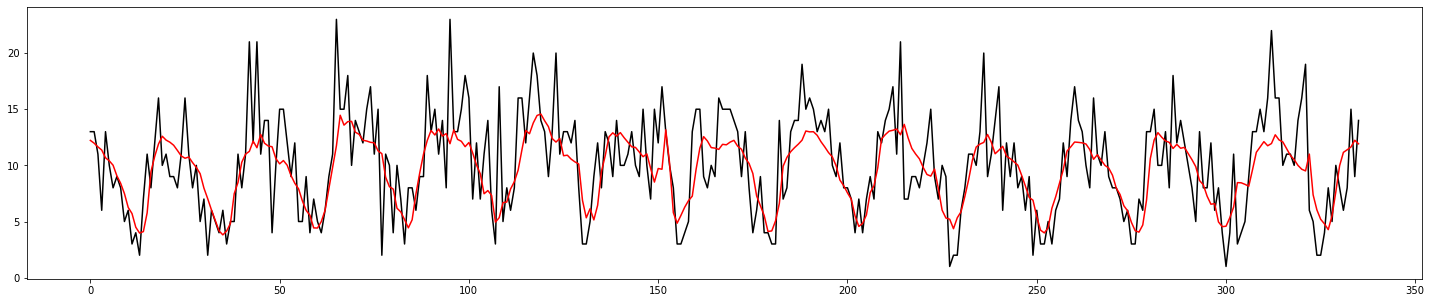

In [17]:
# Plotting predictions vs actual of best model
predictions = pd.to_numeric(min(lstm_grid_search_results, key=lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
sns.lineplot(data=val[24:].values[:24*14], color ='black')
sns.lineplot(data=predictions[:24*14],color='red');

### Round 2 with same hyper parameters

In [18]:
### Redoing with best hyperparameters
lstm_grid_search_results = lstm_with_grid_search(train, val,n_steps_list=[24], batch_size_list=[128], epochs_list=[20])

Model with: n_steps: 24 batch_size: 128 epochs: 20
Epoch 1/20
100252/100252 [==============================] - 58s 579us/step - loss: 11.1862
Epoch 2/20
100252/100252 [==============================] - 51s 505us/step - loss: 10.0660
Epoch 3/20
100252/100252 [==============================] - 66s 657us/step - loss: 10.0047
Epoch 4/20
100252/100252 [==============================] - 47s 470us/step - loss: 9.9500
Epoch 5/20
100252/100252 [==============================] - 50s 495us/step - loss: 9.9185
Epoch 6/20
100252/100252 [==============================] - 52s 520us/step - loss: 9.9123
Epoch 7/20
100252/100252 [==============================] - 53s 528us/step - loss: 9.8944
Epoch 8/20
100252/100252 [==============================] - 58s 578us/step - loss: 9.8737
Epoch 9/20
100252/100252 [==============================] - 53s 527us/step - loss: 9.8662
Epoch 10/20
100252/100252 [==============================] - 57s 570us/step - loss: 9.8582
Epoch 11/20
100252/100252 [==================

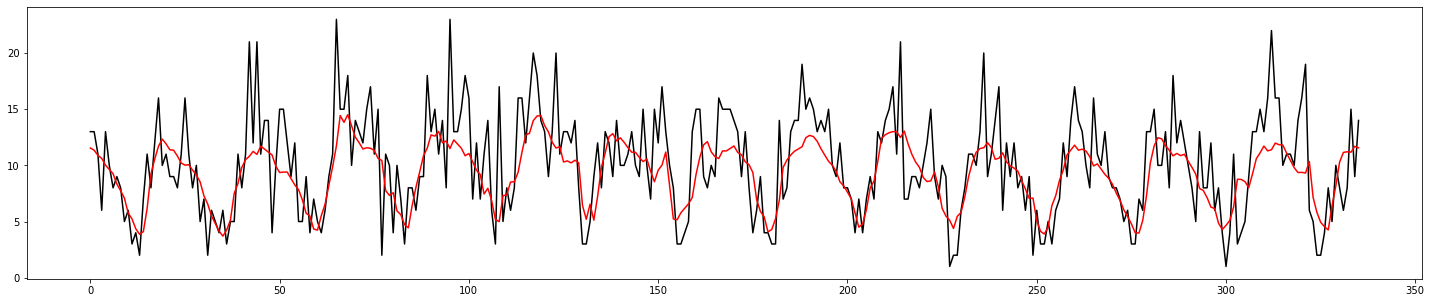

In [19]:
# Plotting predictions vs actual of best model
predictions = pd.to_numeric(min(lstm_grid_search_results, key=lstm_grid_search_results.get)[3])

plt.figure(figsize=(25,5))
sns.lineplot(data=val[24:].values[:24*14], color ='black')
sns.lineplot(data=predictions[:24*14],color='red');

In [20]:
# Pickling lstm hyper parameter dictionary
redo_pickle = True

if redo_pickle == True:
    with open('best_lstm_dict.pickle','wb') as f:
        pickle.dump(lstm_grid_search_results,f)
        
if redo_pickle == False:
    with open('best_lstm_dict.pickle','rb') as f:
        lstm_grid_search_results = pickle.load(f)

TypeError: can't pickle _thread.RLock objects

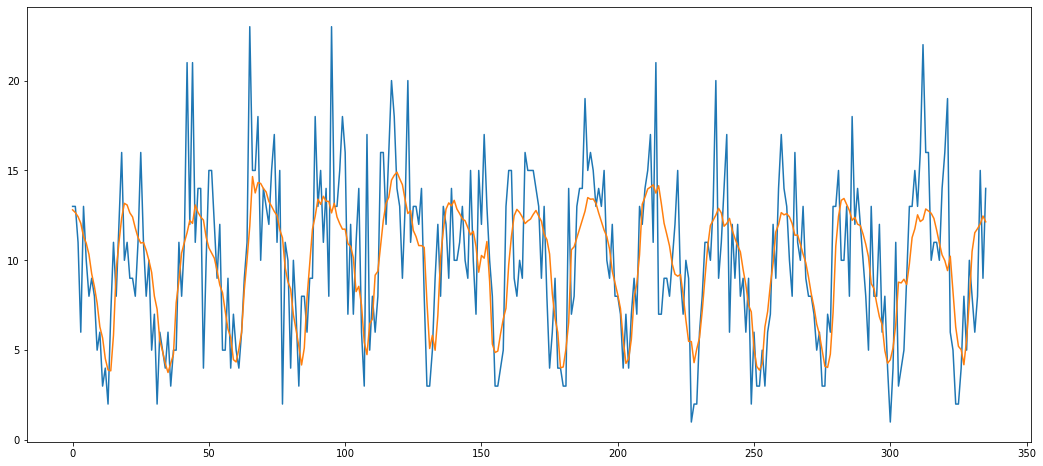

In [152]:
# Plotting predictions vs actual of best model
predictions = pd.to_numeric(min(lstm_grid_search_results, key=lstm_grid_search_results.get)[3])

plt.figure(figsize=(18,8))
sns.lineplot(data=val[24:].values[:24*14])
sns.lineplot(data=predictions[:24*14]);